In [107]:
## Imports
import glob
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from scipy.stats import pearsonr

import skimage
import scipy
from skimage.feature import peak_local_max
from skimage.morphology import watershed

from behavior_utils import *

## Unsupervised Behavior Clustering
1. Once behavior features are defined in track2features.ipynb, save to features.p
2. Name your features in behavior_utils.py
3. Read your features here
4. Perform importance sampling via one round of clustering on unformly sampled data
5. Then sample across those clusters to create a new map.

This analysis is inspired by:

Sample implementation of the MotionMapper behavioral analysis methods initially described in the paper “Mapping the stereotyped behaviour of freely-moving fruit flies” by Berman, GJ, Choi, DM, Bialek, W, and Shaevitz, JW, J. Royal Society Interface, 99, 20140672 (2014).


In [145]:
## Define inputs
Xs = pickle.load(open('features2.p','rb'))
sessions=list(Xs.keys())

N_feats = len(FEATURE_NAMES)

### Uniformly sample data for first round of t-SNE

In [146]:
# Select your number of samples (more is better but takes longer) and 
# perplexity (bigger for more samples, 5-50 is recommended)
PERPLEX_SCALE=100
N_samples=5000 #ideally 12000 (as was used in paper)
perplexity=N_samples/PERPLEX_SCALE

# uniformly sample across time for initial embedding
X = np.concatenate([Xs[s].T for s in sessions])
N_rows, N_cols = X.shape

# Check that your data dimensions fit within your parameters
assert (N_rows >= N_samples or N_cols != N_feats)

i_unif = np.linspace(0,N_rows-1,N_samples).astype(int)
X_unif = X[i_unif]

### First t-SNE embedding, visualization, and perceptron-learning of embedding function to reduce all data to 2D space

In [147]:
X_unif_embedded = TSNE(n_components=2,perplexity=perplexity).fit_transform(X_unif)

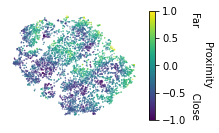

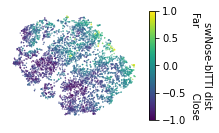

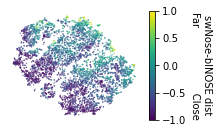

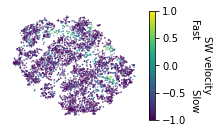

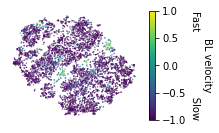

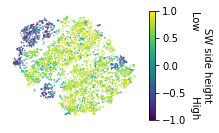

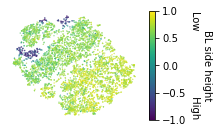

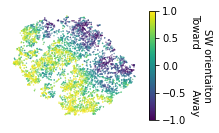

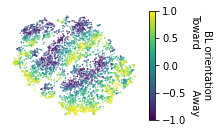

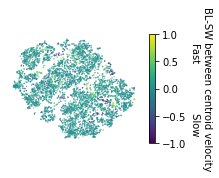

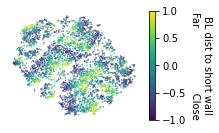

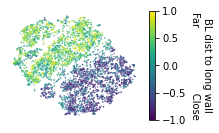

In [174]:
# visualize variables in t-SNE space
for i in range(N_feats):
    plt.figure(figsize=(3,2))
    plt.scatter(X_unif_embedded[:,0],
                X_unif_embedded[:,1],
                c=X_unif[:,i],
                s=500/N_samples)
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.set_label(FEATURE_NAMES[i]+'\n'+FEAT_RANGES[i],
                   rotation=270,va='bottom')
    plt.show()

In [152]:
# learn the non-parametric embedding with a MLP regressor

split = int(N_samples/2) # number of samples to train vs test regressor

X_tr = X_unif[:split]
y_tr = X_unif_embedded[:split]

X_te = X_unif[split:]
y_te = X_unif_embedded[split:]


# fit regression model for mapping from N_feats to 2 t-SNE dimensions
mlp = MLPRegressor(hidden_layer_sizes=(400, 200, 50))
mlp = mlp.fit(X_tr,y_tr)

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [153]:
# predict embedding on test data
pred_te=mlp.predict(X_te)

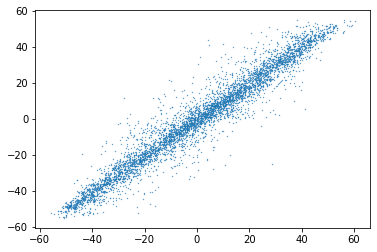

R^2=0.94


In [154]:
# evaluate ability of MLP to match embedding

plt.figure()
plt.scatter(pred_te,y_te,s=500/N_samples)
plt.show()
var_explained = pearsonr(y_te.flatten(),pred_te.flatten())[0]**2
print(r'R^2=%.2f'%var_explained)

In [155]:
X_embedded = mlp.predict(X)

### Create a smoothed 2 histogram and use watershed segmentation to separate "behavior clusters"

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


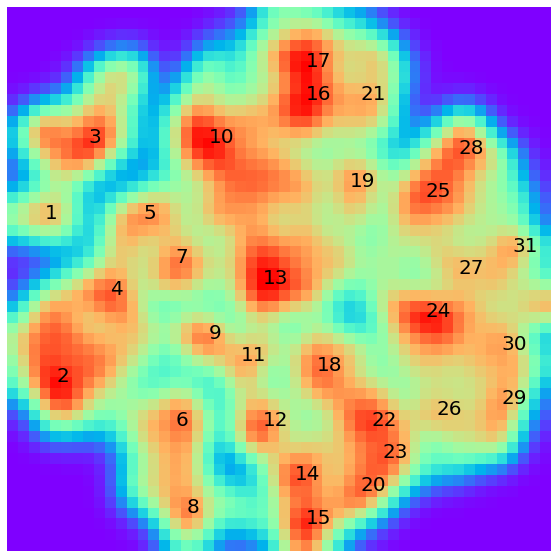

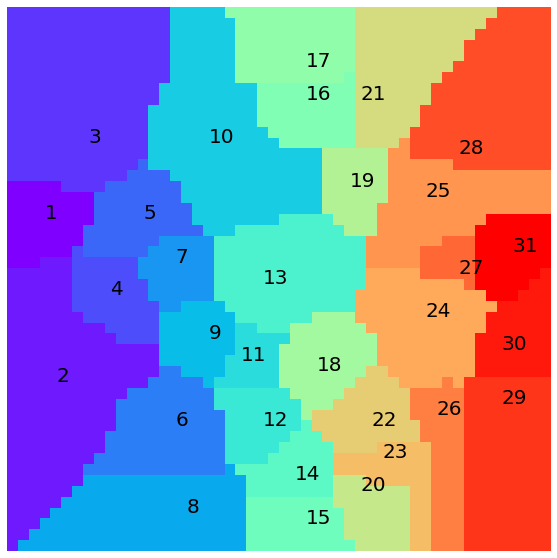

In [168]:
def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    """Generates gaussian-filtered 2D histogram of 2D data

    Args:
        data: Nx2 numerical array
        axlims: The leftmost and rightmost edges of the bins along each 
                dimension (if not specified explicitly in the bins parameters): 
                [[xmin, xmax], [ymin, ymax]]. 
                All values outside of this range will be considered outliers 
                and not tallied in the histogram.
        bins:   If int, the number of bins for the two dimensions (nx=ny=bins).
                If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
                If [int, int], the number of bins in each dimension (nx, ny = bins).
                If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
                A combination [int, array] or [array, int], where int is the number of bins and 
                array is the bin edges.
        normed: Default true, returns the probability density function at the bin, 
                bin_count / sample_count / bin_area.
                If false, returns count per bin.
        sigma:  scalar or sequence of scalers, standard deviation(s) for Gaussian kernel.
                The standard deviations of the Gaussian filter are given for each axis as a 
                sequence, or as a single number, in which case it is equal for all axes.



    Returns: 
        2D array of filtered histogram, 
        1D array of bin edges in dim 0, 
        1D array of bin edges in dim 1
    
    """
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

# Parameters to change as needed
sigma = 1.5
percentile = 30
n_bins = 50

# Find local maxima as "seeds" for the watershed tranlsform
all_map_density,xe,ye = heatmap(X_embedded, bins=n_bins, sigma=sigma)
density_cutoff = np.percentile(all_map_density, percentile)
density_mask = all_map_density > density_cutoff
local_maxes = peak_local_max(all_map_density, indices=False)
local_maxes[np.logical_not(density_mask)] = False
markers, n_peaks = scipy.ndimage.label(local_maxes)

# Compute watershed transform
labeled_map = watershed(-all_map_density, markers, watershed_line=False)
labeled_map = labeled_map.astype('float64')

labeled_map_viz = watershed(-all_map_density, markers, watershed_line=False)
labeled_map_viz = labeled_map_viz.astype('float64')

viz = all_map_density
viz[labeled_map_viz==0]=0

#Visualize
plt.figure(figsize=(10,10))
plt.imshow(all_map_density.T,cmap='rainbow',origin='lower')
for i in np.unique(labeled_map.flatten()):
    x = np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y = np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    plt.text(x, y, int(i), size=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(labeled_map.T,cmap='rainbow',origin='lower')
plt.axis('off')
for i in np.unique(labeled_map.flatten()):
    x = np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y = np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    plt.text(x, y, int(i), size=20)
plt.show()

### Generate embeddings and cluster assignments across each video

In [158]:
embeddings = {}
for k in sessions:
    test_X = Xs[k]
    embedded_mlp = mlp.predict(test_X.T)
    embeddings[k] = embedded_mlp

In [159]:
def to_coords(xy):
    """Continuous 2D point to bin ID in 2D histogram.

    Args:
        xy: 2x1 array or tuple

    Returns:
        x bin (int)
        y bin (int)
    
    """

    x = (xy[0] - xmin) / (xmax - xmin) * map_shape[0]
    y = (xy[1] - ymin) / (ymax - ymin) * map_shape[1]
    if x >= map_shape[0]:
        x = map_shape[0]-1
    if y >= map_shape[1]:
        y = map_shape[1]-1
    if x < 0:
        x=0
    if y < 0:
        y=0
    return int(x), int(y)


map_shape=(n_bins,n_bins)
xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)

labels = {}

for k,e in embeddings.items():
    labels[k] = np.array([labeled_map[to_coords(point)] for point in e])

## Sample across clusters in first embedding (importance sampling)

In [160]:
# Importance sampling
feats_sampled=[]

for k,labs in labels.items():
    for l in np.unique(labs):
        indices=np.where(labs==l)[0]
        np.random.shuffle(indices)
        
        # Weighted sampling acriss clusters in initial embedding
        if l==1:
            feats_sampled.append(Xs[k].T[indices[:20]])
        else:
            feats_sampled.append(Xs[k].T[indices[:10]])

X_importance_sampled =np.row_stack(feats_sampled)
X_importance_sampled.shape

m3242_csds5 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3228_csds7 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3233_csds2 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3229_csds7 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3228_csds6 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3242_csds1 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3240_csds4 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3233_csds7 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3231_csds6 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3227_csds4 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3234_csds5 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3230_csds3 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3242_csds4 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3230_csds10 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3228_csds1 [ 1.  2

m3231_csds8 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3242_csds9 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3232_csds8 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3229_csds6 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3245_csds9 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3240_csds6 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3230_csds9 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3239_csds1 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3228_csds2 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3241_csds4 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3239_csds5 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3236_csds2 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3236_csds8 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3239_csds8 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
m3230_csds8 [ 1.  2.

(24000, 12)

## Learn second embedding from importance sampled frames

In [161]:
X_embedded = TSNE(n_components=2,perplexity=perplexity).fit_transform(X_importance_sampled)

In [162]:
mlp2 = MLPRegressor(hidden_layer_sizes=(400, 200, 50))
mlp2= mlp2.fit(X_importance_sampled, X_embedded)

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


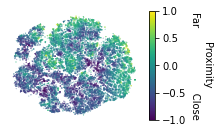

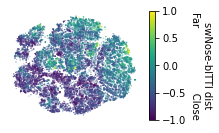

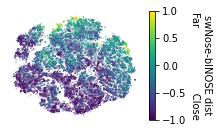

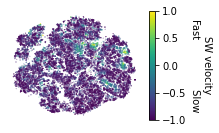

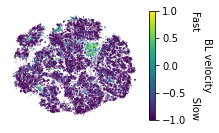

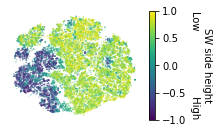

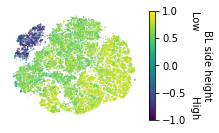

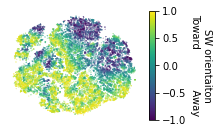

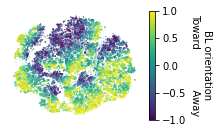

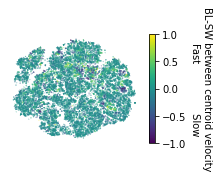

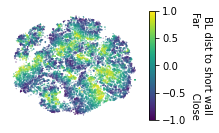

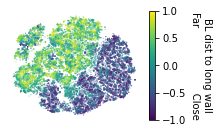

In [175]:
# visualize variables in t-SNE space
for i in range(N_feats):
    plt.figure(figsize=(3,2))
    plt.scatter(X_embedded[:,0],
                X_embedded[:,1],
                c=X_importance_sampled[:,i],
                s=500/len(X_embedded))
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.set_label(FEATURE_NAMES[i]+'\n'+FEAT_RANGES[i],
                   rotation=270,va='bottom')
    plt.show()

In [164]:
embeddings2={}
for k in Xs.keys():
    X = Xs[k].T
    embedded_mlp = mlp2.predict(X)
    embeddings2[k]=embedded_mlp

/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/usr/people/willmore/.conda/envs/umap/lib/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,

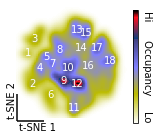

In [169]:
X_pred = np.row_stack(embeddings2.values())
# Find local maxima as "seeds" for the watershed tranlsform
all_map_density,xe,ye = heatmap(X_pred, bins=50, sigma=sigma)
density_cutoff = np.percentile(all_map_density, percentile)
density_mask = all_map_density > density_cutoff
local_maxes = peak_local_max(all_map_density, indices=False)
local_maxes[np.logical_not(density_mask)] = False
markers, n_peaks = scipy.ndimage.label(local_maxes)

# Compute watershed transform
labeled_map = watershed(-all_map_density, markers, watershed_line=False)
labeled_map = labeled_map.astype('float64')

labeled_map_viz = watershed(-all_map_density, markers, watershed_line=True)
labeled_map_viz = labeled_map_viz.astype('float64')

labeled_map2=labeled_map.copy()
for i in range(1,49):
    for j in range(1,49):
        a=labeled_map[i][j]!=labeled_map[i-1][j]
        b=labeled_map[i][j]!=labeled_map[i+1][j]
        c=labeled_map[i][j]!=labeled_map[i][j-1]
        d=labeled_map[i][j]!=labeled_map[i][j+1]
        if a or b or c or d:
            labeled_map2[i][j]=0

viz = all_map_density.copy()


plt.figure(figsize=(2.2,2.2))
im=plt.imshow(viz.T,cmap='gist_stern_r',origin='lower')
xlist=[]
ylist=[]
for i in np.unique((labeled_map).flatten()):
    x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    xlist.append(x)
    ylist.append(y)
    plt.text(x,y,int(i),size=10,
            verticalalignment='center',
            horizontalalignment='center',
            color='white')
cbar=plt.colorbar(im,fraction=0.046)
cbar.set_ticks([])
cbar.set_label('Hi      Occupancy     Lo',rotation=-90,va='bottom')

plt.vlines(x=0,ymin=-2,ymax=10,color='k')
plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10)
plt.hlines(y=-2,xmin=0,xmax=12,color='k')
plt.text(1,-2.8,'t-SNE 1',size=10,verticalalignment='top')
plt.axis('off')
plt.show()

## New final cluster assignments

In [170]:
map_shape=(n_bins,n_bins)
xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)

labels = {}

for k,e in embeddings2.items():
    labels[k] = np.array([labeled_map[to_coords(point)] for point in e])

## Save data maps, embeddings, and cluster labels

In [ ]:
saved = {}
saved['map'] = labeled_map
saved['projection'] = mlp2
saved['embeddings'] = embeddings2
saved['labels'] = labels